In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2

train_dir = '/Users/idayeong/Desktop/Dataset/Train'

In [8]:
# crop the center square of an image (100,100)
def center_crop(image, label, crop_size=100): 
    height, width, _ = image.shape[1:] 
    crop_size = min(height, width, crop_size)
    center_x = width // 2
    center_y = height // 2
    cropped_image = image[:, center_y - crop_size // 2:center_y + crop_size // 2,
                     center_x - crop_size // 2:center_x + crop_size // 2, :]

    return cropped_image, label

# set image size
IMG_SIZE = (100, 100)  # size reducing 256 to 100

# image train dataset ; one-hot coding, batch size, image size
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 batch_size=32,
                                                                 image_size=IMG_SIZE,
                                                                 color_mode='grayscale')

# apply the crop function
train_data = train_data.map(lambda x, y: center_crop(x, y, crop_size=100))

# split dataset for Train and Test
train_size = int(0.8 * len(train_data))
test_size = len(train_data) - train_size
train_dataset = train_data.take(train_size)
test_dataset = train_data.skip(train_size)

# from Train dataset split dataset for Validation
validation_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - validation_size
train_dataset = train_dataset.take(train_size)
validation_dataset = train_dataset.skip(train_size - validation_size)

# print to determine the Size of Divided Datasets
print("Train data count:", len(train_dataset))
print("Validation data count:", len(validation_dataset))
print("Test data count:", len(test_dataset))

Found 140002 files belonging to 2 classes.
Train data count: 3150
Validation data count: 350
Test data count: 876
Shape of the image after preprocessing: (None, 100, 100, 1)
Shape of the image after preprocessing: (None, 100, 100, 1)
Shape of the image after preprocessing: (None, 100, 100, 1)


In [9]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

# Define model
model = models.Sequential()

# Convolutional Layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 2
model.add(layers.Conv2D(64, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten Layer
model.add(layers.Flatten())

# Fully Connected Layer
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output Layer
model.add(layers.Dense(2, activation='softmax')) 


optimizer = Adam(learning_rate=0.0001)

# Deliver the optimizer set in the optimizer parameter when compiling the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
                       tf.keras.metrics.F1Score(average=None, name='f1_score'),
                       tf.keras.metrics.LogCoshError()])

model.summary()

try:
    # Train the model
    model.fit(train_dataset, epochs=5, validation_data=validation_dataset)
except Exception as e:
    print("An error occurred during training:")
    print(str(e))


# Model evaluation
test_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_logloss = model.evaluate(test_dataset)

print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1-Score: {test_f1_score}')
print(f'Test Logarithmic Loss: {test_logloss}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 33856)             0         
                                                                 
 dense (Dense)               (None, 64)                2

In [82]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path for test directory
test_dir = '/Users/idayeong/Desktop/Dataset/Test'

# Function to crop the center square of an image
def center_crop(image):
    crop_size = 100  # Assuming we want a 100x100 crop
    height, width, _ = image.shape
    startx = width // 2 - (crop_size // 2)
    starty = height // 2 - (crop_size // 2)
    return image[starty:starty + crop_size, startx:startx + crop_size]

# Create an ImageDataGenerator for preprocessing the images
# Including the central crop in the preprocessing_function
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=center_crop
) 

test_dataset = test_datagen.flow_from_directory(
    test_dir,  
    target_size=(100, 100),  # Size is larger than crop to ensure the crop is possible
    color_mode='grayscale',  
    batch_size=32, 
    class_mode='categorical',  
    shuffle=False
) 

# Output the classes found in the test dataset directory
print("Test dataset classes:", test_dataset.class_indices)


Found 10905 images belonging to 2 classes.
Test dataset classes: {'Fake': 0, 'Real': 1}


1/1 [==============================] - 0s 34ms/step
Predicted Label: 0 (Confidence: 54.45%)
True Label: 0


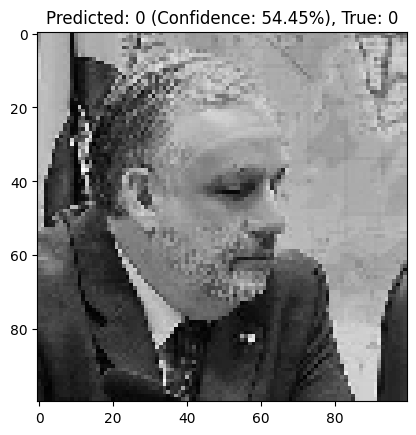

In [93]:
# Select a random image from the test dataset
batch = next(iter(test_dataset))  # Retrieve the first batch
images, labels = batch[0], batch[1]  # Separate images and labels

# Choose a random image
idx = np.random.randint(0, images.shape[0])
random_image = images[idx]
true_label = labels[idx]

# Predict the class using the model
prediction = model.predict(np.expand_dims(random_image, axis=0))

# The predicted label is the one with the highest probability
predicted_label = np.argmax(prediction, axis=1)[0]

# probability of prediction
predicted_probability = np.max(prediction) * 100 


# The true label is the one that corresponds to the actual image
true_label_idx = np.argmax(true_label)


# Output the results and visualize the image
print(f'Predicted Label: {predicted_label} (Confidence: {predicted_probability:.2f}%)')
print(f'True Label: {true_label_idx}')
plt.imshow(np.squeeze(random_image), cmap='gray') 
plt.title(f'Predicted: {predicted_label} (Confidence: {predicted_probability:.2f}%), True: {true_label_idx}')
plt.show()